# RNA velocity analysis of neuron cells(Male)

In [88]:
import numpy as np
import loompy
import scvelo as scv
import velocyto as vcy
import pandas as pd 
import scanpy as sc
import cellrank as cr
import matplotlib.pyplot as plt
import os

In [138]:
adata_neuron_combined = sc.read_h5ad("../../01.rds_files/Neuron.combined.h5ad")

In [139]:
n_gene=30
groupby='Cell_Type'
cosg.cosg(adata_neuron_combined,
    key_added='cosg',
    # use_raw=False, layer='log1p', ## e.g., if you want to use the log1p layer in adata
    mu=100,
    expressed_pct=0.1,
    remove_lowly_expressed=True,
     n_genes_user=100,
               groupby=groupby)

**finished identifying marker genes by COSG**


In [140]:
sc.tl.dendrogram(adata_neuron_combined,groupby=groupby,use_rep='X_pca')

In [141]:
df_tmp=pd.DataFrame(adata_neuron_combined.uns['cosg']['names'][:3,]).T
df_tmp=df_tmp.reindex(adata_neuron_combined.uns['dendrogram_'+groupby]['categories_ordered'])
marker_genes_list={idx: list(row.values) for idx, row in df_tmp.iterrows()}
marker_genes_list = {k: v for k, v in marker_genes_list.items() if not any(isinstance(x, float) for x in v)}



/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:737: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  dot_ax.scatter(x, y, **kwds)


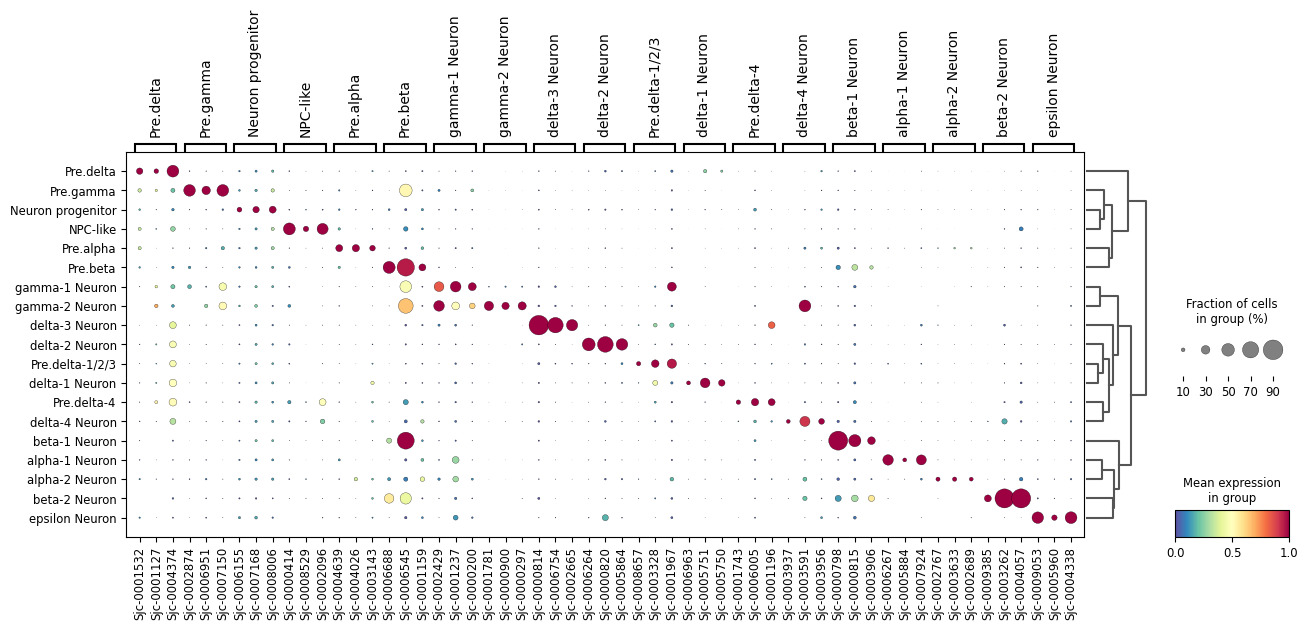

In [149]:
sc.pl.dotplot(adata_neuron_combined, marker_genes_list,
             groupby=groupby,
             dendrogram=True,
              swap_axes=False,
             standard_scale='var',figsize=[15,5],save="FigS6A.pdf",
             cmap='Spectral_r')

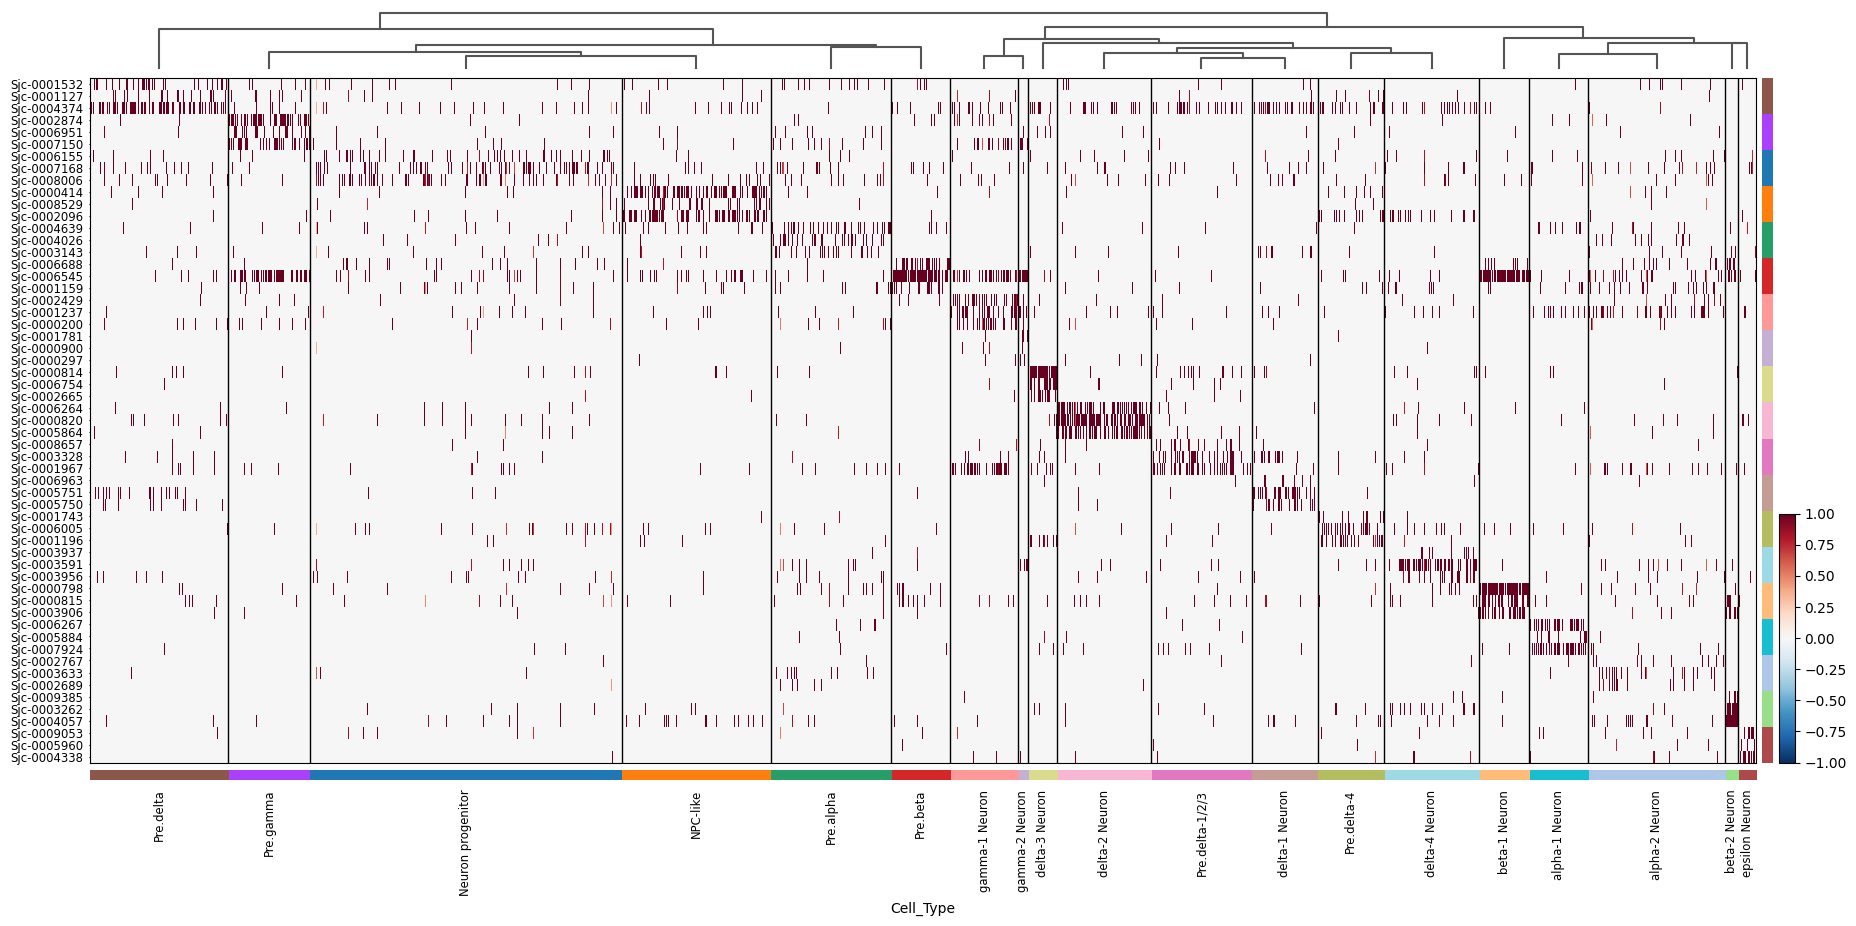

In [148]:
sc.pl.heatmap(
    adata_neuron_combined,
    marker_genes_list,
    groupby=groupby,
    #layer="counts",
    vmin=-1,
    vmax=1,
    cmap="RdBu_r",show_gene_labels=True,
    dendrogram=True,
    swap_axes=True,
    figsize=(22,10),save="FigS6A.pdf"
)



/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:453: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:453: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:453: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:453: UserWarning: Numpy array is not a supported type for `palette`. Pleas

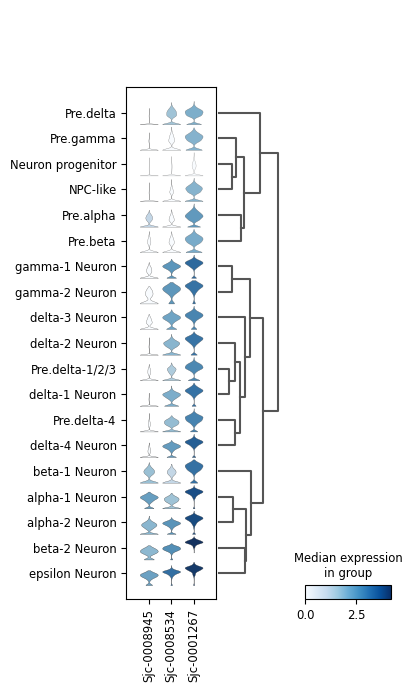

In [219]:
sc.pl.stacked_violin(adata_neuron_combined, ["Sjc-0008945","Sjc-0008534","Sjc-0001267"],groupby=groupby, dendrogram=True,save="FigS6A_2.pdf")

In [1]:


def Pre_process(filename,mode = None,n_jobs = 80):
    
    # read spliced/unspliced files from 
    spliced = np.array(pd.read_csv(filename + '.spliced.txt',sep='\t',index_col=0))
    unspliced = np.array(pd.read_csv(filename + '.unspliced.txt', sep='\t',index_col=0))
    ambiguous = np.array(pd.read_csv(filename + '.ambigous.txt',sep='\t',index_col=0))

    cells = pd.read_csv(filename + '.celltype.csv')
    cellid = np.array(cells.barcode)
    seurat_clusters = np.array(cells.Cell_Type)
    genes = pd.read_csv(filename+ '.genes.csv')
    genes = np.array(genes.x)

    ## 创建loom文件
    col_attr = {"CellID": cellid}
    row_attr = {"Gene": genes}
    loompy.create(filename + '_new.cells.loom', spliced,row_attr,col_attr)
    lm = loompy.connect(filename +'_new.cells.loom')
    lm['spliced'] = spliced
    lm['unspliced'] = unspliced
    lm['ambiguous'] = ambiguous
    lm.ca['clusters'] = seurat_clusters
    lm.close()

    ## scvelo分析
    adata = scv.read_loom(filename + '_new.cells.loom')
    scv.pp.filter_and_normalize(adata,min_shared_counts=20, n_top_genes=2000)

    scv.pp.moments(adata, n_pcs=30, n_neighbors=30) # Computes moments for velocity estimation.
    scv.pp.remove_duplicate_cells(adata)
    scv.pp.neighbors(adata)

    if mode == "dynamical":
        scv.tl.recover_dynamics(adata,n_jobs = n_jobs)
        scv.tl.velocity(adata, mode='dynamical')
        scv.tl.velocity_graph(adata)
    else:
        scv.tl.velocity(adata)
        scv.tl.velocity_graph(adata)
    
    ## 添加umap坐标信息
    umap = pd.read_csv(filename + '.umap.csv',sep=',',index_col=0)
    adata.obsm['X_umap'] = np.vstack((umap['UMAP_1'].values, umap['UMAP_2'].values)).T
    return adata

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10002. The TBB threading layer is disabled.
  warnings.warn(problem)


In [30]:
root_dir  = "/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/"
filenames = [os.path.join(root_dir,f,f.replace("_loom","")) for f in os.listdir(root_dir)]
filenames

['/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Neoblast.combined_loom/Neoblast.combined',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Female_GSCs_loom/Female_GSCs',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Male_GSCs_loom/Male_GSCs',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Male_seob_neuron_loom/Male_seob_neuron',
 '/home/shycheng/Projects/SingleCell_Sja2024/04.velocity/Female_seob_neuron_loom/Female_seob_neuron']

In [50]:
adata_m_old = sc.read_h5ad("../../04.velocity/Male_seob_neuron_loom/Male_seob_neuron_celltype_loom.h5ad")

# 加载CSV文件
cells = pd.read_csv(filenames[3] + '.celltype.csv', index_col='barcode')

# 更新anndata对象的细胞注释
# 确保cells的索引与adata_m_old.obs的索引对应
adata_m_old.obs['clusters'] = adata_m_old.obs.index.map(cells['Cell_Type'])

adata_m_old.obs['clusters'] = adata_m_old.obs['clusters'].astype('category')

# Set the categories with an ordered flag
adata_m_old.obs['clusters'].cat.set_categories([
    'Neuron progenitor', 'NPC-like', 'Pre.alpha', 'Pre.beta',
    'Pre.gamma', 'Pre.delta', 'Pre.delta-1/2/3', 'Pre.delta-4',
    'alpha-1 Neuron', 'alpha-2 Neuron', 'beta-1 Neuron', 'beta-2 Neuron',
    'gamma-1 Neuron', 'gamma-2 Neuron', 'delta-1 Neuron', 'delta-2 Neuron',
    'delta-3 Neuron', 'delta-4 Neuron', 'epsilon Neuron'
], ordered=True, inplace=True)

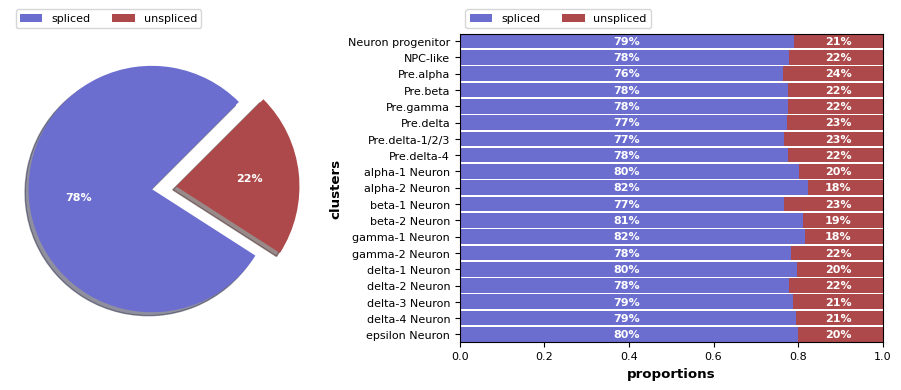

In [51]:
scv.pl.proportions(adata_m_old,figsize=[12,4])

saving figure to file ../../02.figures/FigS7/FigS7C.pdf


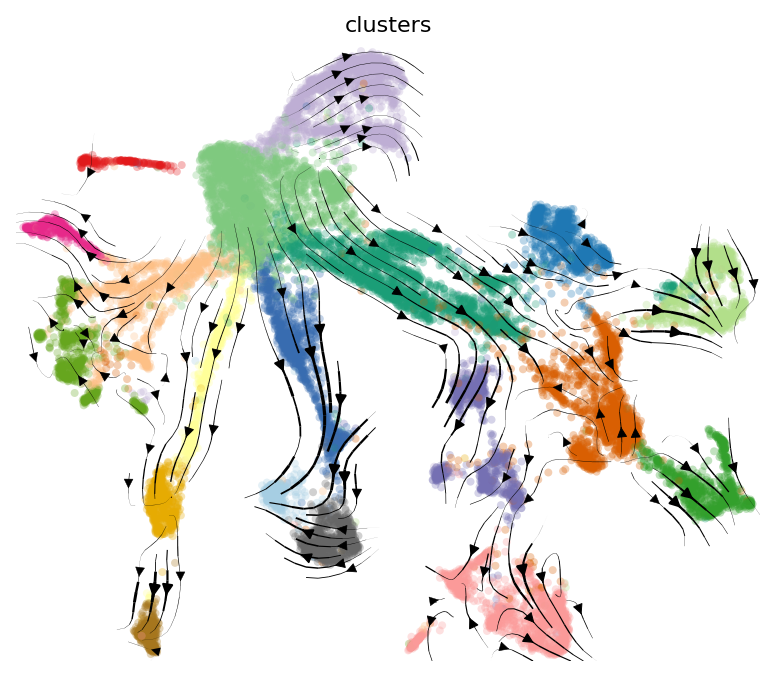

In [165]:
cb_palette = ["#7FC97F" ,"#BEAED4", "#FDC086", "#FFFF99" ,
              "#386CB0" ,"#1B9E77", "#D95F02", "#7570B3",
              "#E7298A" ,"#66A61E", "#E6AB02", "#A6761D" ,
              "#666666" ,"#A6CEE3", "#1F78B4", "#B2DF8A",
              "#33A02C" ,"#FB9A99", "#E31A1C"]
# dynamic mode
scv.pl.velocity_embedding_stream(adata_m_old, basis='umap',dpi=160,linewidth=0.8,legend_fontsize='8',colorbar=True,figsize=[6,5],
                                 palette=cb_palette ,legend_loc='none',save='../../02.figures/FigS7/FigS7C.pdf')

In [ ]:
cr.tl.initial_states(
    adata_m_old,
    cluster_key="clusters",
    n_cells=30,
    softmax_scale=4,#estimator=
    n_states=1,
    show_progress_bar=False)

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file ../../02.figures/FigS7/FigS7D_a.pdf


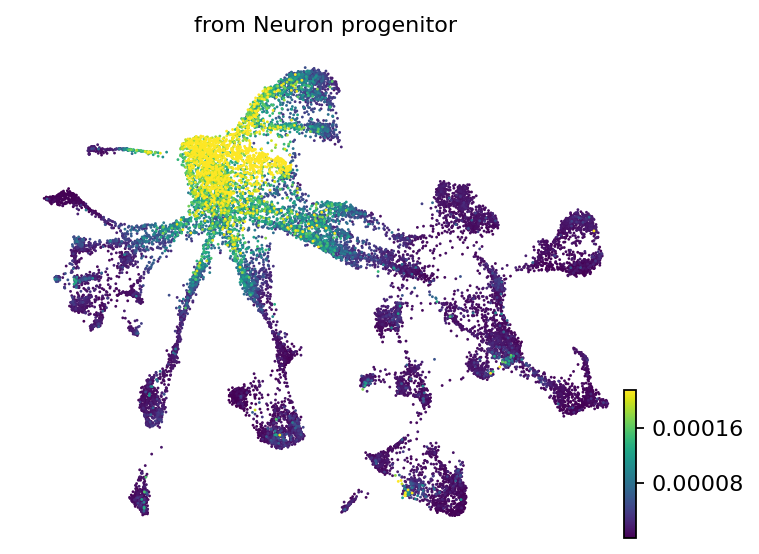

In [151]:
cr.pl.initial_states(adata_m_old,legend_loc='right out',dpi = 160,figsize= [5,4],) # save = "../../02.figures/FigS7/FigS7D_a.pdf"

In [ ]:
cr.tl.terminal_states(
    adata_m_old,
    cluster_key="clusters",
    n_cells=30,
    softmax_scale=4,
    n_states=6,
    show_progress_bar=False,
    n_jobs = 16)

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/cellrank/tl/_utils.py:1219: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a_fuzzy.shape, dtype=np.bool
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/cellrank/tl/_utils.py:1282: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if membership.dtype != np.bool:
/ho

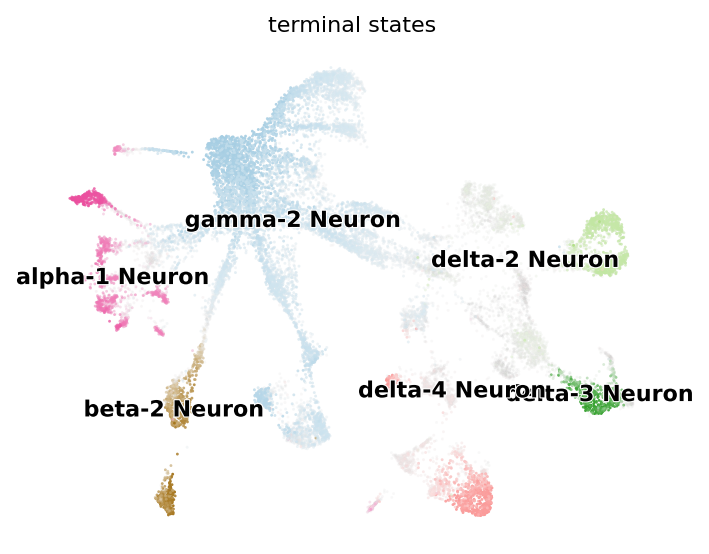

In [61]:
cr.pl.terminal_states(adata_m_old,legend_loc='on data',dpi = 160,figsize= [5,4],) # save = "../../02.figures/FigS7/FigS7D_b.pdf"

In [157]:
cr.tl.lineages(adata_m_old)
# compue dpt, starting from CellRank defined root cell
root_idx = np.where(adata_m_old.obs['initial_states'] == 'Neuron progenitor')[0][0]
adata_m_old.uns['iroot'] = root_idx
sc.tl.dpt(adata_m_old)

scv.tl.paga(
    adata_m_old,
    groups="clusters",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="dpt_pseudotime",
)

  0%|          | 0/180 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


running PAGA using priors: ['dpt_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:04) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


## FigS10CD

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plo

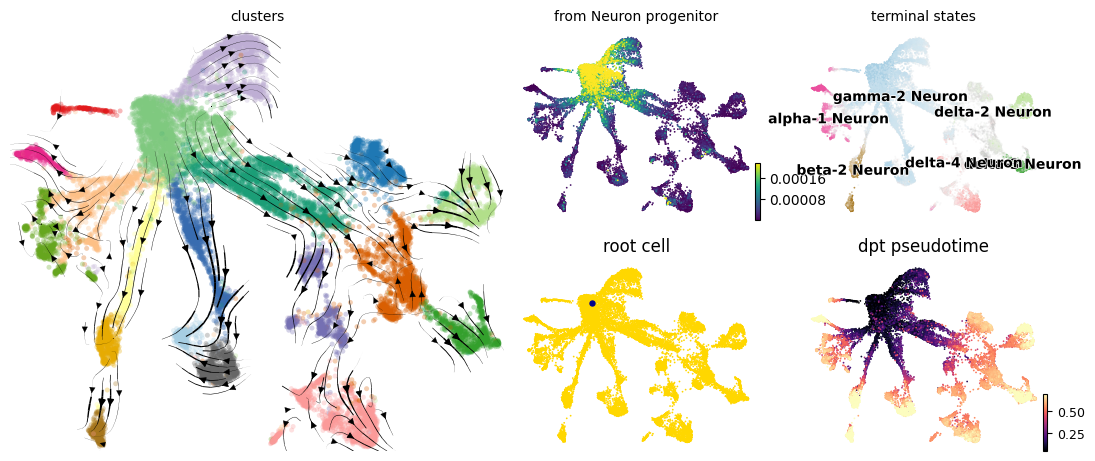

In [193]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scanpy as sc
import scvelo as scv  # 确保这些库被正确导入

# 设置画布和网格布局
fig = plt.figure(figsize=(10.8, 4.5),constrained_layout=True)  # 设置整体图形的大小
gs = gridspec.GridSpec(2, 3, width_ratios=[2,1, 1],figure=fig)  # 2行3列

# 单独的图形在右侧
ax5 = plt.subplot(gs[:, 0])  # 这个子图跨越所有行
scv.pl.velocity_embedding_stream(adata_m_old, basis='umap', dpi=160, linewidth=0.8, legend_fontsize='8', 
                                 colorbar=True,  palette=cb_palette, legend_loc='none', ax=ax5, show=False)

# 2x2 子图布局在左侧两列
ax1 = plt.subplot(gs[0, 1])
cr.pl.initial_states(adata_m_old, ax=ax1, legend_loc='right out', dpi=160, show=False)

ax2 = plt.subplot(gs[0, 2])
cr.pl.terminal_states(adata_m_old, ax=ax2, legend_loc='on data', dpi=160, show=False)


ax3 = plt.subplot(gs[1, 1])
scv.pl.scatter(adata_m_old, color=[root_idx], fontsize=12, ax=ax3,
               cmap='magma', perc=[10, 90], colorbar=True,
               title='root cell', legend_loc='on data', show=False)

ax4 = plt.subplot(gs[1, 2])
scv.pl.scatter(adata_m_old, color=['dpt_pseudotime'], fontsize=12, ax=ax4,
               cmap='magma', perc=[10, 90], colorbar=True,
               title='dpt pseudotime', legend_loc='on data', show=False)

# # 新的跨所有列的子图
# ax6 = plt.subplot(gs[2, :])  # 跨越所有列的新行
# cr.pl.cluster_fates(adata_m_old, mode="paga_pie", cluster_key="clusters", basis='umap',
#                     legend_kwargs={'loc': 'top right out'}, legend_loc='top left out',
#                     node_size_scale=3, edge_width_scale=1, max_edge_width=2, title='directed PAGA', dpi=320, ax=ax6, show=False)



# # 调整布局
# plt.tight_layout()

plt.savefig('../../02.figures/FigS7/FigS7CD.pdf')

plt.show()

## FigS10E

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/cellrank/pl/_cluster_fates.py:488: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.array(mask, dtype=np.bool)
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/cellrank/tl/_lineage.py:423: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if item_1.dtype == 

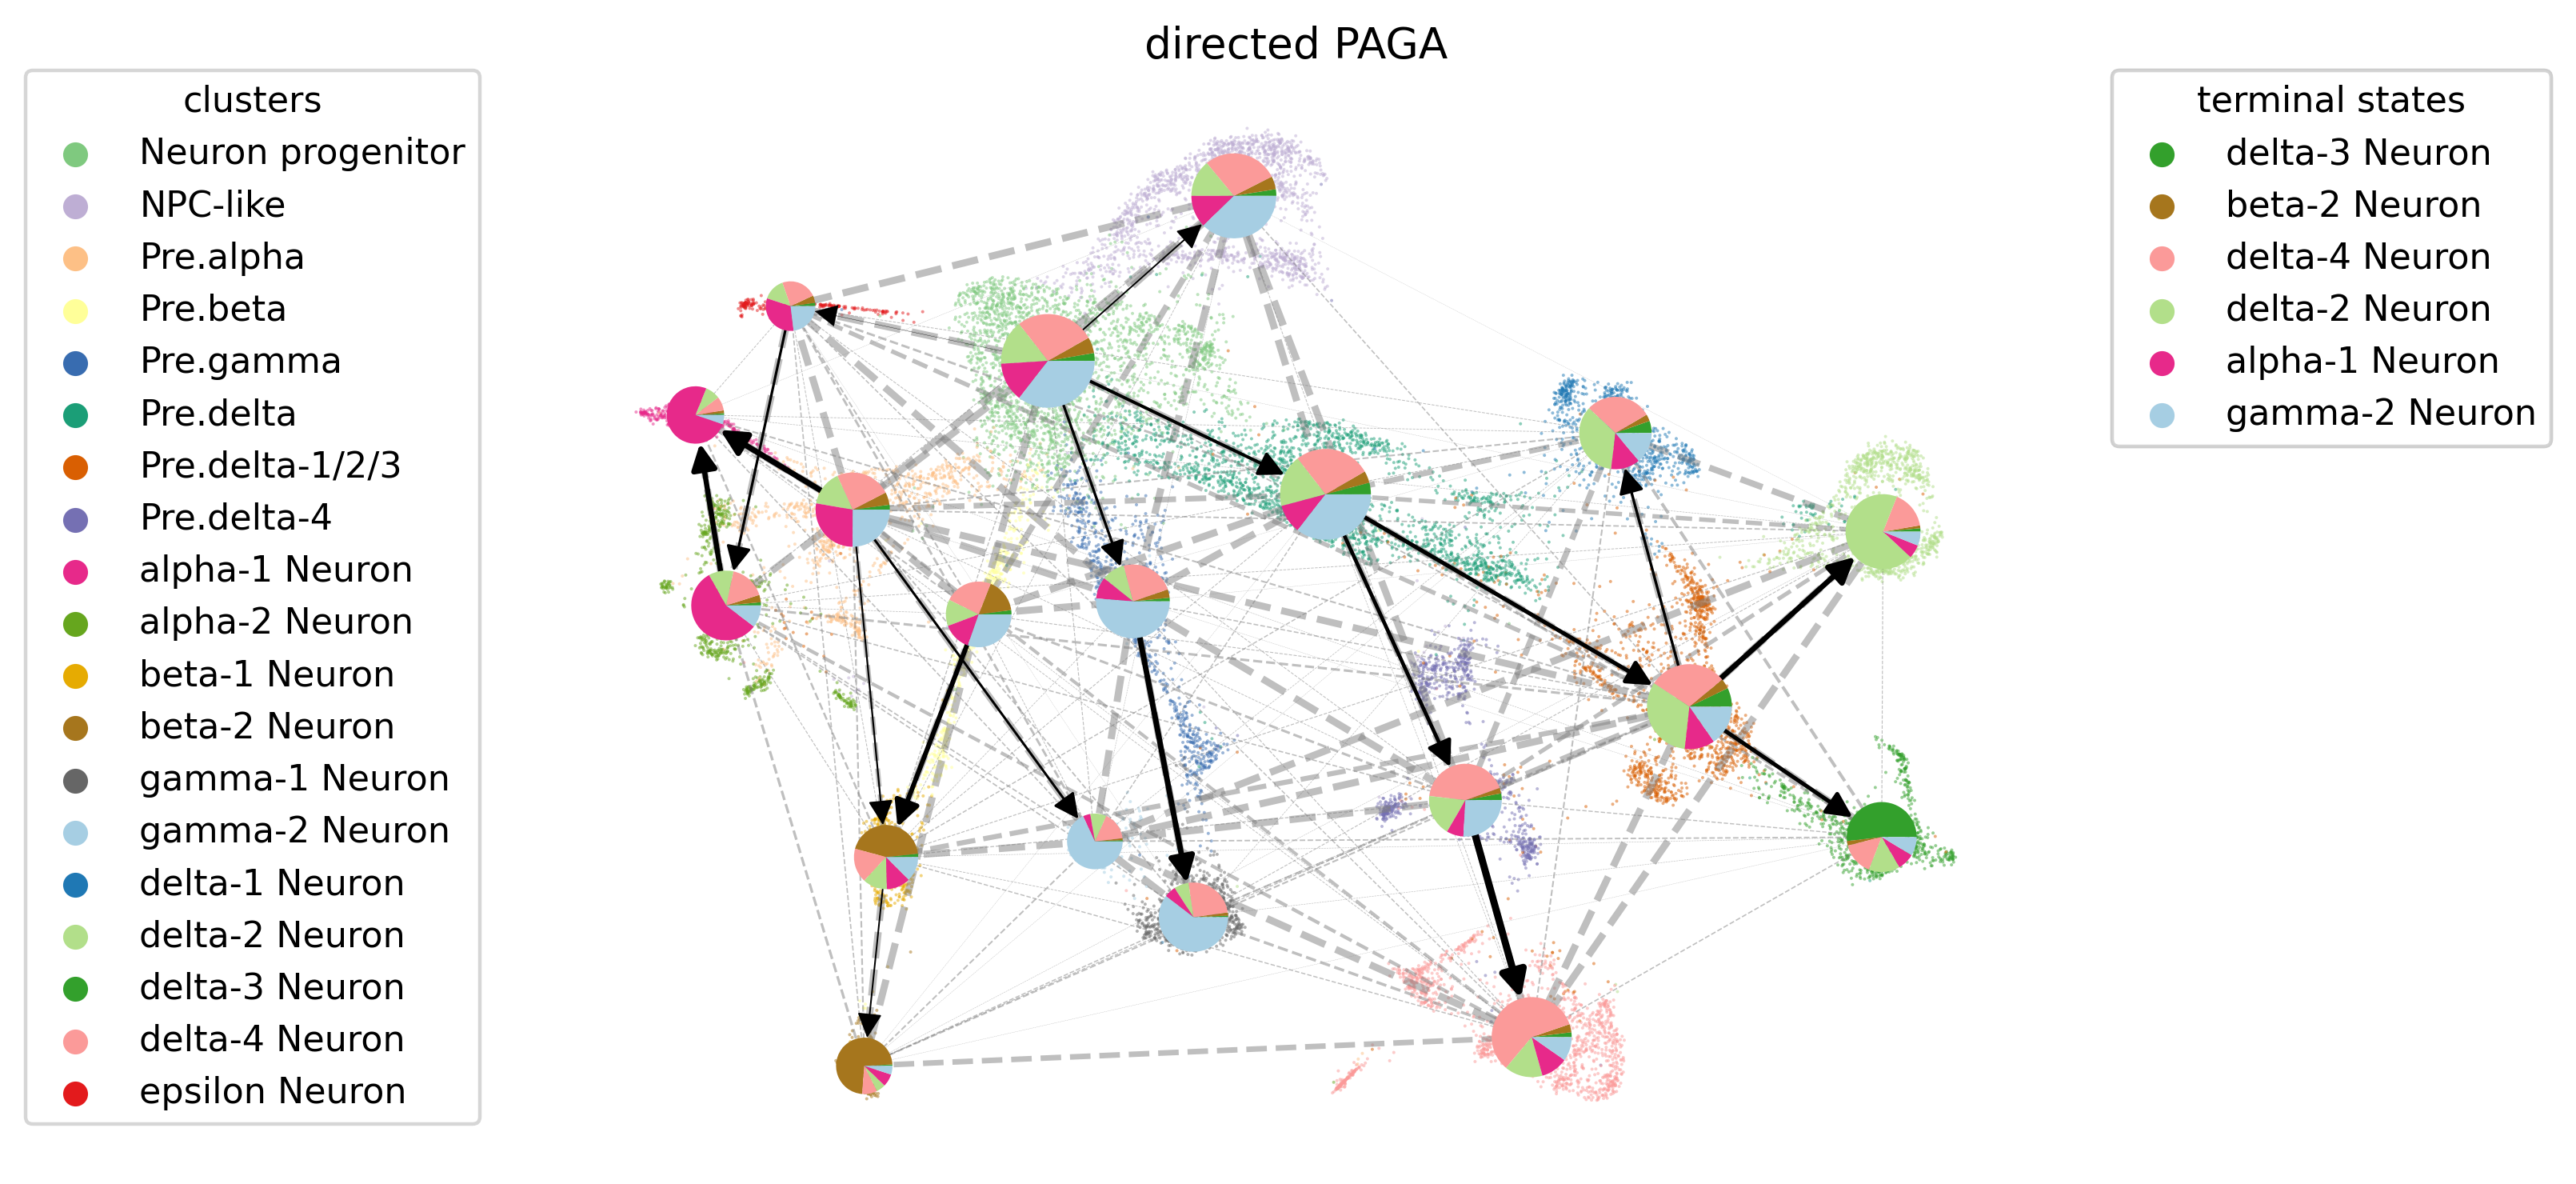

In [196]:
# 单独处理 cluster_fates 图形
cr.pl.cluster_fates(adata_m_old, mode="paga_pie", cluster_key="clusters", basis='umap',
                    legend_kwargs={'loc': 'top right out'}, legend_loc='top left out',
                    node_size_scale=3, edge_width_scale=1, max_edge_width=2, title='directed PAGA', dpi=320,
                    save='../../02.figures/FigS7/FigS7E.pdf')  # 保存图形或直接显示

Filtered out 2151 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:06) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/256 cores)


  0%|          | 0/18575 [00:00<?, ?cells/s]

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:01:24) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


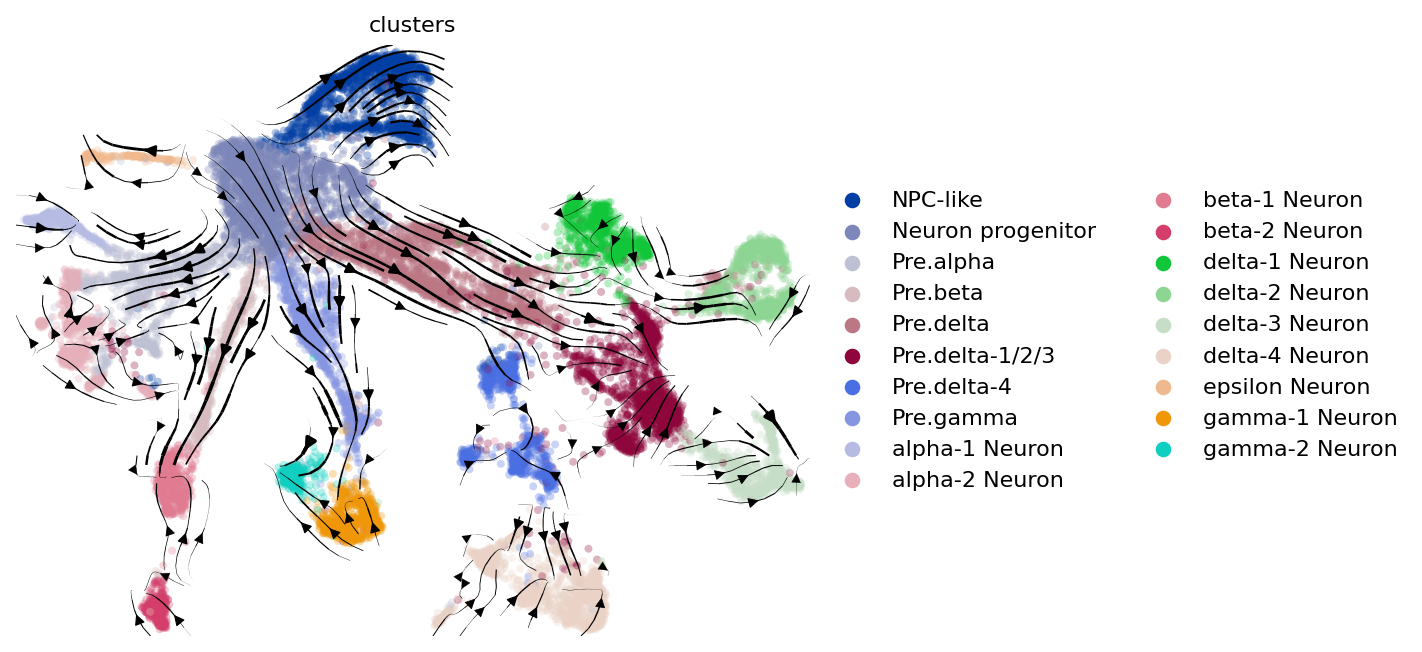

In [9]:
# adata_m = Pre_process(filenames[3],mode="dynamic")
# scv.pl.velocity_embedding_stream(adata_m, basis='umap',legend_loc='right margin',xlabel='umap1',ylabel='umap2',dpi=160)

In [65]:
scv.tl.recover_latent_time(
    adata_m_old, root_key="initial_states_probs", end_key="terminal_states_probs"
)

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:08) --> added 
    'latent_time', shared time (adata.obs)


In [197]:
cr.tl.lineage_drivers(adata_m_old,method = "fischer",n_jobs = 1)

delta-3 Neuron corr  delta-3 Neuron pval  delta-3 Neuron qval  \
Gene                                                                         
Sjc-0006755             0.788638                  0.0                  NaN   
Sjc-0000814             0.734548                  0.0                  NaN   
Sjc-0006754             0.650855                  0.0                  NaN   
Sjc-0000373             0.587001                  0.0                  NaN   
Sjc-0003639             0.538524                  0.0                  NaN   
...                          ...                  ...                  ...   
Sjc-0008513                  NaN                  NaN                  NaN   
Sjc-0005726                  NaN                  NaN                  NaN   
Sjc-0009447                  NaN                  NaN                  NaN   
Sjc-0000119                  NaN                  NaN                  NaN   
Sjc-0009749                  NaN                  NaN                  NaN   

             delta-3 Neuron ci low  delta-3 Neuron ci high  \
Gene                                                         
Sjc-0006755               0.783139                0.794014   
Sjc-0000814               0.727856                0.741100   
Sjc-0006754               0.642488                0.659067   
Sjc-0000373               0.577495                0.596348   
Sjc-0003639               0.528234                0.548656   
...                            ...                     ...   
Sjc-0008513                    NaN                     NaN   
Sjc-0005726                    NaN                     NaN   
Sjc-0009447                    NaN                     NaN   
Sjc-0000119                    NaN                     NaN   
Sjc-0009749                    NaN                     NaN   

             beta-2 Neuron corr  beta-2 Neuron pval  beta-2 Neuron qval  \
Gene                                                                      
Sjc-0006755           -0.074390        3.096776e-24                 NaN   
Sjc-0000814           -0.057816        3.072449e-15                 NaN   
Sjc-0006754           -0.056922        8.122224e-15                 NaN   
Sjc-0000373           -0.049710        1.201042e-11                 NaN   
Sjc-0003639            0.384268        0.000000e+00                 NaN   
...                         ...                 ...                 ...   
Sjc-0008513                 NaN                 NaN                 NaN   
Sjc-0005726                 NaN                 NaN                 NaN   
Sjc-0009447                 NaN                 NaN                 NaN   
Sjc-0000119                 NaN                 NaN                 NaN   
Sjc-0009749                 NaN                 NaN                 NaN   

             beta-2 Neuron ci low  beta-2 Neuron ci high  ...  \
Gene                                                      ...   
Sjc-0006755             -0.088676              -0.060074  ...   
Sjc-0000814             -0.072137              -0.043471  ...   
Sjc-0006754             -0.071245              -0.042576  ...   
Sjc-0000373             -0.064046              -0.035355  ...   
Sjc-0003639              0.371942               0.396458  ...   
...                           ...                    ...  ...   
Sjc-0008513                   NaN                    NaN  ...   
Sjc-0005726                   NaN                    NaN  ...   
Sjc-0009447                   NaN                    NaN  ...   
Sjc-0000119                   NaN                    NaN  ...   
Sjc-0009749                   NaN                    NaN  ...   

             alpha-1 Neuron corr  alpha-1 Neuron pval  alpha-1 Neuron qval  \
Gene                                                                         
Sjc-0006755            -0.102778         7.060251e-45                  NaN   
Sjc-0000814            -0.076681         1.179468e-25                  NaN   
Sjc-0006754            -0.078264         1.163314e-26    

## Fig3D

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


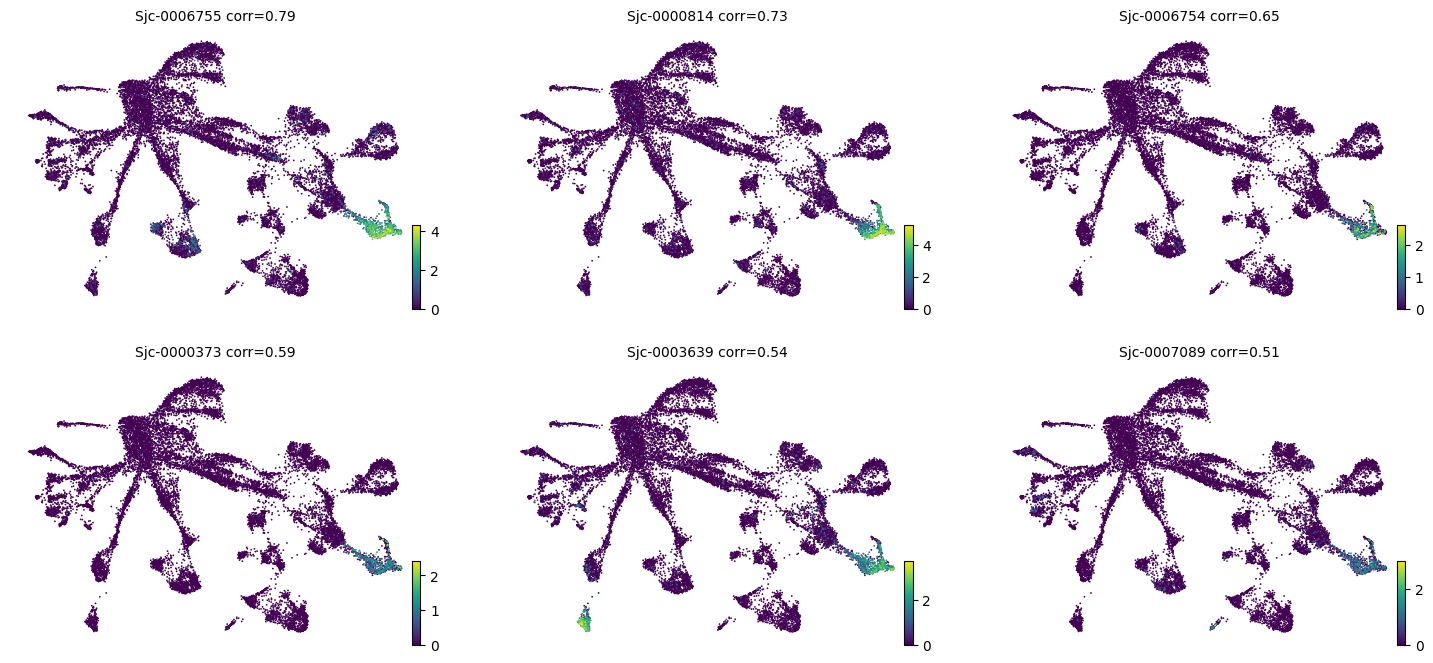

In [199]:
cr.pl.lineage_drivers(adata_m_old,
                      lineage="delta-3 Neuron",
                      n_genes=6,ncols=3,
                      title_fmt= '{gene} corr={corr:.2}',colorbar=True,save = "../../02.figures/FigS7F.pdf")

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


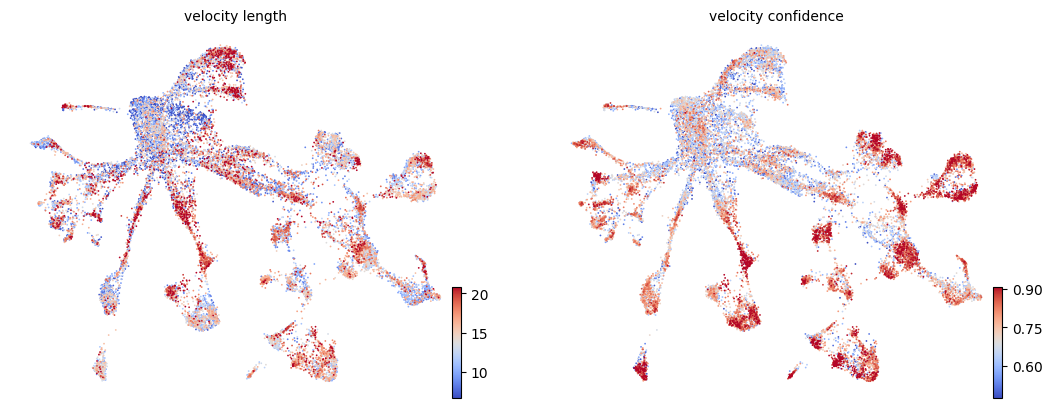

In [68]:
scv.tl.velocity_confidence(adata_m_old)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata_m_old, c=keys, cmap='coolwarm', perc=[5, 95])

# RNA velocity analysis of neuron cells(Female)

In [69]:
adata_f = Pre_process(filenames[4])

adata_f.obs['clusters'].cat.set_categories([
    'Neuron progenitor', 'NPC-like', 'Pre.alpha', 'Pre.beta',
    'Pre.gamma', 'Pre.delta', 'Pre.delta-1/2/3', 'Pre.delta-4',
    'alpha-1 Neuron', 'alpha-2 Neuron', 'beta-1 Neuron', 'beta-2 Neuron',
    'gamma-1 Neuron', 'gamma-2 Neuron', 'delta-1 Neuron', 'delta-2 Neuron',
    'delta-3 Neuron', 'delta-4 Neuron', 'epsilon Neuron'
], ordered=True, inplace=True)

Filtered out 2308 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/256 cores)


  0%|          | 0/17343 [00:00<?, ?cells/s]

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - proce

    finished (0:01:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


saving figure to file ../../02.figures/FigS8/FigS8C.svg


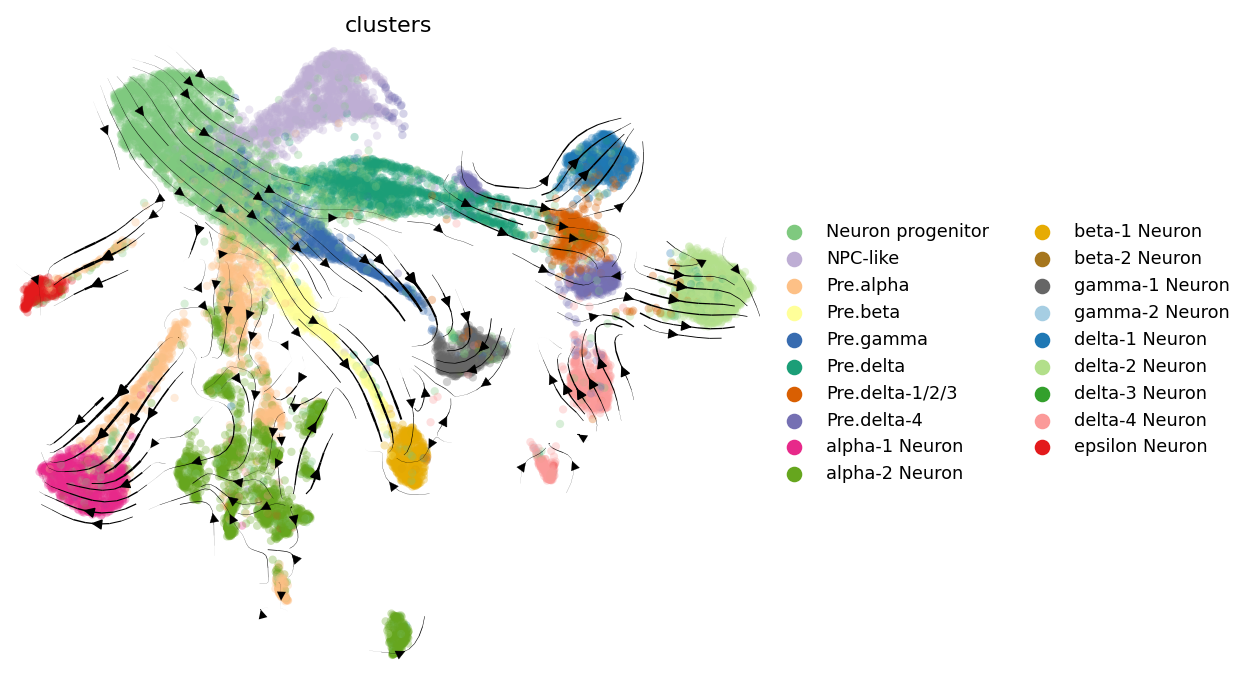

In [204]:
# dyanmic mode
scv.pl.velocity_embedding_stream(adata_f, basis='umap',dpi=160,linewidth=0.8,legend_fontsize='8',colorbar=True,figsize=[6,5],
                                 palette=cb_palette ,legend_loc='right',save='../../02.figures/FigS8/FigS8C.svg') # 

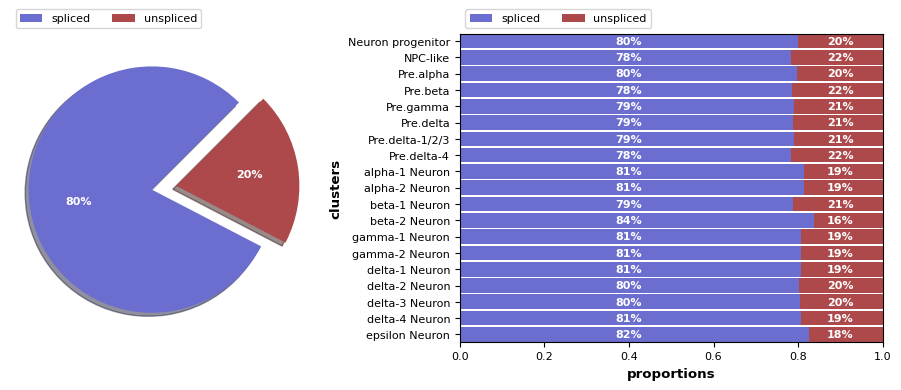

In [71]:
scv.pl.proportions(adata_f,figsize=[12,4])

dynamic mode

In [72]:
scv.tl.recover_dynamics(adata_f,n_jobs = 20)
scv.tl.velocity(adata_f, mode='dynamical')
scv.tl.velocity_graph(adata_f)

recovering dynamics (using 20/256 cores)


  0%|          | 0/1346 [00:00<?, ?gene/s]

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:01:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:14) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/256 cores)


  0%|          | 0/17343 [00:00<?, ?cells/s]

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:01:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [75]:
cr.tl.initial_states(
    adata_f,
    cluster_key="clusters",
    n_cells=30,#estimator=cr.tl.estimators.CFLARE,
    softmax_scale=4,
    n_states=1,
    show_progress_bar=False)

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/cellrank/tl/_utils.py:1219: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a_fuzzy.shape, dtype=np.bool
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/cellrank/tl/_utils.py:1282: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if membership.dtype != np.bool:
/ho

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


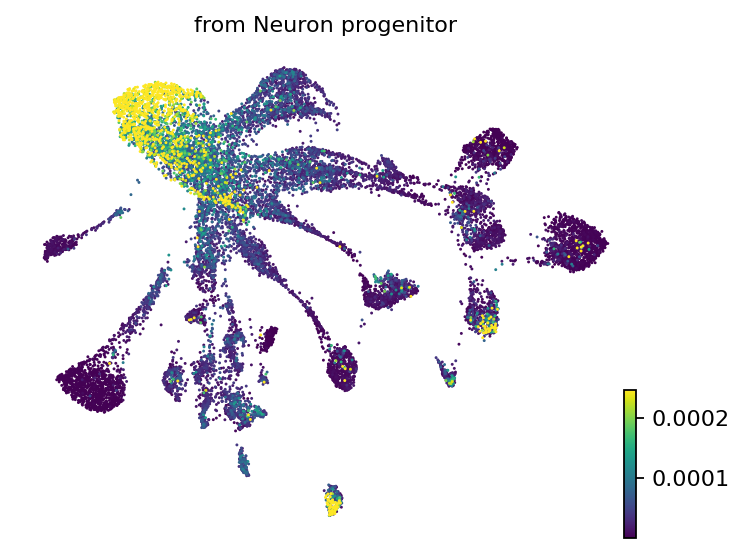

In [76]:
cr.pl.initial_states(adata_f,legend_loc='right out',dpi = 160,figsize= [5,4],) # save = "../../02.figures/FigS7/FigS7E_a.pdf"

In [77]:
cr.tl.terminal_states(
    adata_f,
    cluster_key="clusters",
    n_cells=30,
    softmax_scale=4,
    n_states=6,
    show_progress_bar=False,
    n_jobs = 16)

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/cellrank/tl/_utils.py:1219: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a_fuzzy.shape, dtype=np.bool
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/cellrank/tl/_utils.py:1282: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if membership.dtype != np.bool:
/ho

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


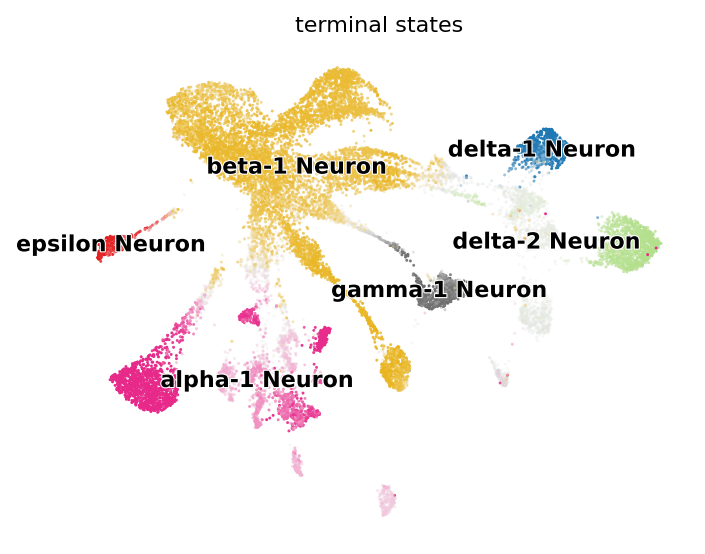

In [79]:
cr.pl.terminal_states(adata_f,legend_loc='on data',dpi = 160,figsize= [5,4],)

In [80]:
import numpy as np
import pandas as pd
import scipy.sparse

# 指定细胞类型和基因名
cell_type = "Neuron progenitor"
gene_name = "Sjc-0005962"

# 确保基因名在变量名中
if gene_name in adata_f.var_names:
    # 过滤出特定细胞类型的细胞
    filtered_cells = adata_f[adata_f.obs["clusters"] == cell_type]

    # 获取该基因的表达量数据
    gene_expression = filtered_cells[:, gene_name].X

    # 如果使用稀疏矩阵，需要转换
    if scipy.sparse.issparse(gene_expression):
        gene_expression = gene_expression.toarray()

    # 找到表达量最高的细胞的索引（在过滤后的数据中）
    root_idx_filtered = np.argmax(gene_expression.flatten())

    # 将索引映射回原始数据的索引
    root_idx = filtered_cells.obs.index[root_idx_filtered]

    # 设置起始细胞
    rootidx =  np.where(adata_f.obs.index == root_idx)[0][0]
else:
    print(f"Gene {gene_name} not found in the variable names.")

    
cr.tl.lineages(adata_f)

# compue dpt, starting from CellRank defined root cell
adata_f.uns['iroot'] = rootidx
sc.tl.dpt(adata_f)

scv.tl.paga(
    adata_f,
    groups="clusters",
    root_key="initial_states_probs",
    end_key="terminal_states_probs",
    use_time_prior="dpt_pseudotime",
)

  0%|          | 0/180 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


running PAGA using priors: ['dpt_pseudotime', 'initial_states_probs', 'terminal_states_probs']
    finished (0:00:04) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


figure cannot be saved as pdf, using png instead.
saving figure to file ../../02.figures/FigS8/FigS8C.png


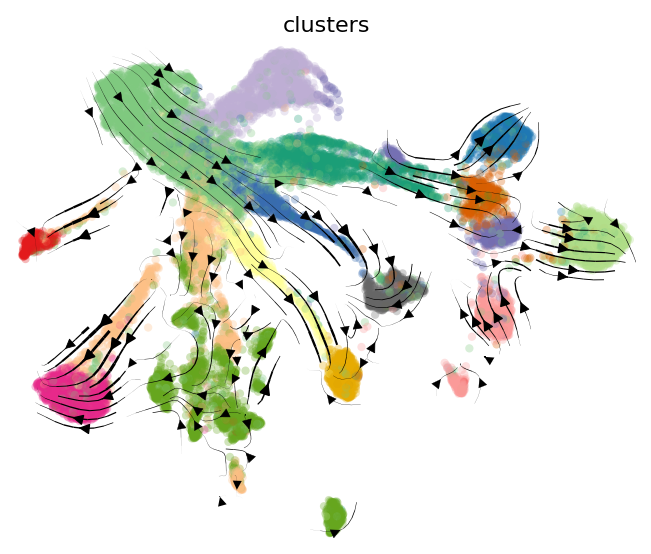

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file ../../02.figures/FigS8/FigS8D_a.pdf


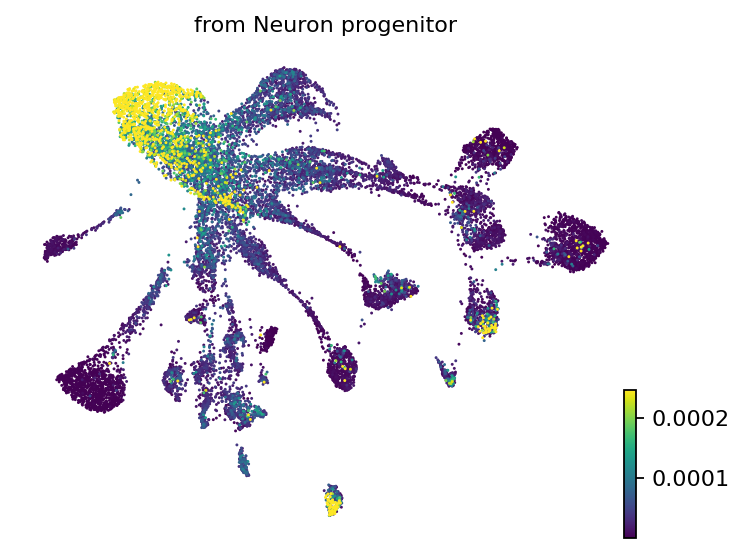

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ../../02.figures/FigS8/FigS8D_b.pdf


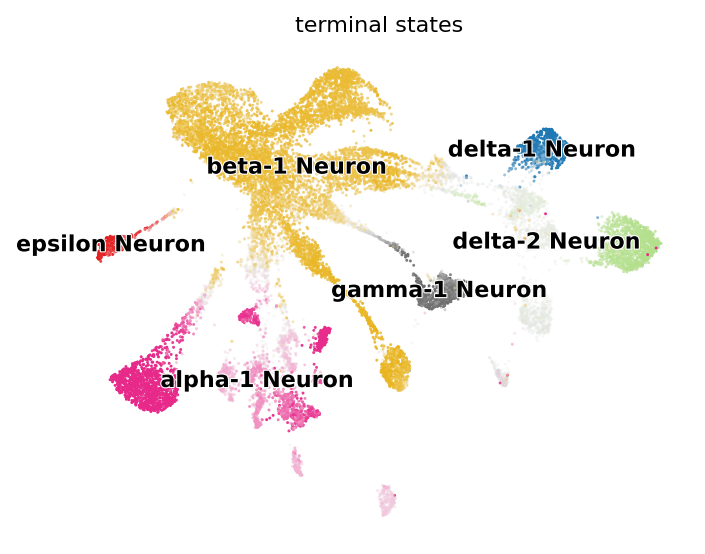

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


saving figure to file ../../02.figures/FigS8/FigS8D_c.pdf


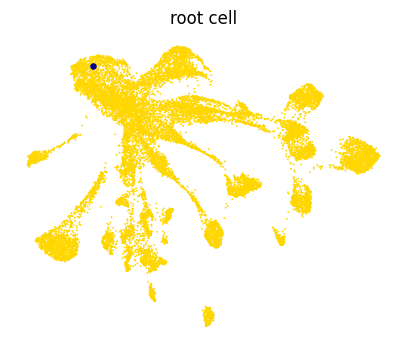

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


saving figure to file ../../02.figures/FigS8/FigS8D_d.pdf


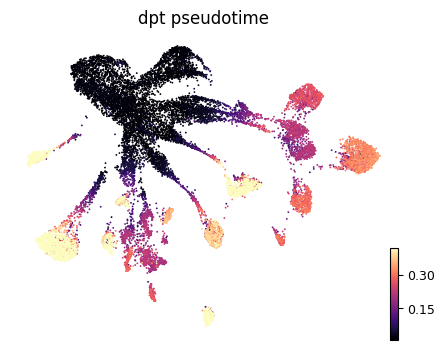

In [224]:
scv.pl.velocity_embedding_stream(adata_f, basis='umap', dpi=160, linewidth=0.8, legend_fontsize='8', 
                                 colorbar=True,  palette=cb_palette, legend_loc='none', figsize = [5,4], save = "../../02.figures/FigS8/FigS8C.pdf")

# 2x2 子图布局在左侧两列

cr.pl.initial_states(adata_f,  legend_loc='right out', dpi=160,figsize = [5,4], save = "../../02.figures/FigS8/FigS8D_a.pdf")


cr.pl.terminal_states(adata_f, legend_loc='on data', dpi=160, figsize = [5,4], save = "../../02.figures/FigS8/FigS8D_b.pdf")


scv.pl.scatter(adata_f, color=[rootidx], fontsize=12, 
               cmap='magma', perc=[10, 90], colorbar=True,
               title='root cell', legend_loc='on data', figsize = [5,4], save = "../../02.figures/FigS8/FigS8D_c.pdf")

scv.pl.scatter(adata_f, color=['dpt_pseudotime'], fontsize=12,
               cmap='magma', perc=[10, 90], colorbar=True,
               title='dpt pseudotime', legend_loc='on data', figsize = [5,4], save = "../../02.figures/FigS8/FigS8D_d.pdf")

## FigS11CD

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plo

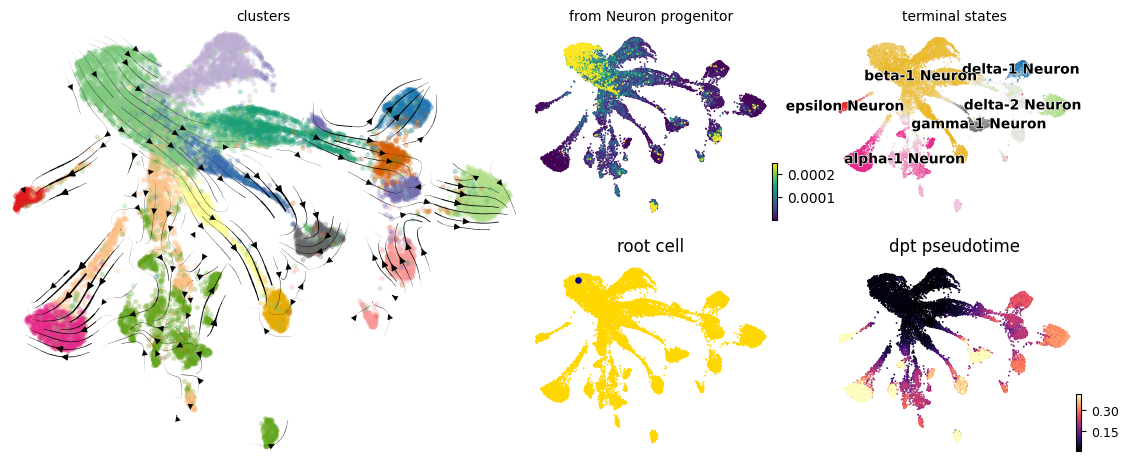

In [222]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scanpy as sc
import scvelo as scv  # 确保这些库被正确导入

# 设置画布和网格布局
fig = plt.figure(figsize=(10.8, 4.5),constrained_layout=True)  # 设置整体图形的大小
gs = gridspec.GridSpec(2, 3, width_ratios=[2,1, 1],figure=fig)  # 2行3列

# 单独的图形在右侧
ax5 = plt.subplot(gs[:, 0])  # 这个子图跨越所有行
scv.pl.velocity_embedding_stream(adata_f, basis='umap', dpi=160, linewidth=0.8, legend_fontsize='8', 
                                 colorbar=True,  palette=cb_palette, legend_loc='none', ax=ax5, show=False)

# 2x2 子图布局在左侧两列
ax1 = plt.subplot(gs[0, 1])
cr.pl.initial_states(adata_f, ax=ax1, legend_loc='right out', dpi=160, show=False)

ax2 = plt.subplot(gs[0, 2])
cr.pl.terminal_states(adata_f, ax=ax2, legend_loc='on data', dpi=160, show=False)


ax3 = plt.subplot(gs[1, 1])
scv.pl.scatter(adata_f, color=[rootidx], fontsize=12, ax=ax3,
               cmap='magma', perc=[10, 90], colorbar=True,
               title='root cell', legend_loc='on data', show=False)

ax4 = plt.subplot(gs[1, 2])
scv.pl.scatter(adata_f, color=['dpt_pseudotime'], fontsize=12, ax=ax4,
               cmap='magma', perc=[10, 90], colorbar=True,
               title='dpt pseudotime', legend_loc='on data', show=False)

# # 新的跨所有列的子图
# ax6 = plt.subplot(gs[2, :])  # 跨越所有列的新行
# cr.pl.cluster_fates(adata_m_old, mode="paga_pie", cluster_key="clusters", basis='umap',
#                     legend_kwargs={'loc': 'top right out'}, legend_loc='top left out',
#                     node_size_scale=3, edge_width_scale=1, max_edge_width=2, title='directed PAGA', dpi=320, ax=ax6, show=False)



# # 调整布局
# plt.tight_layout()

plt.savefig('../../02.figures/FigS8/FigS8CD.svg')

plt.show()

In [223]:
!inkscape ../../02.figures/FigS8/FigS8CD.svg -A ../../02.figures/FigS8/FigS8CD.pdf

In [221]:
import cairosvg

# Convert SVG to PDF
cairosvg.svg2pdf(url='../../02.figures/FigS8/FigS8CD.svg', write_to='../../02.figures/FigS8/FigS8CD.pdf')

#os.remove('../../02.figures/FigS8/FigS8CD.svg')

# !inkscape ../../02.figures/FigS8/FigS8CD.svg -A ../../02.figures/FigS8/FigS8CD.pdf

## FigS11E

/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/cellrank/pl/_cluster_fates.py:488: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.array(mask, dtype=np.bool)
/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/cellrank/tl/_lineage.py:423: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if item_1.dtype == 

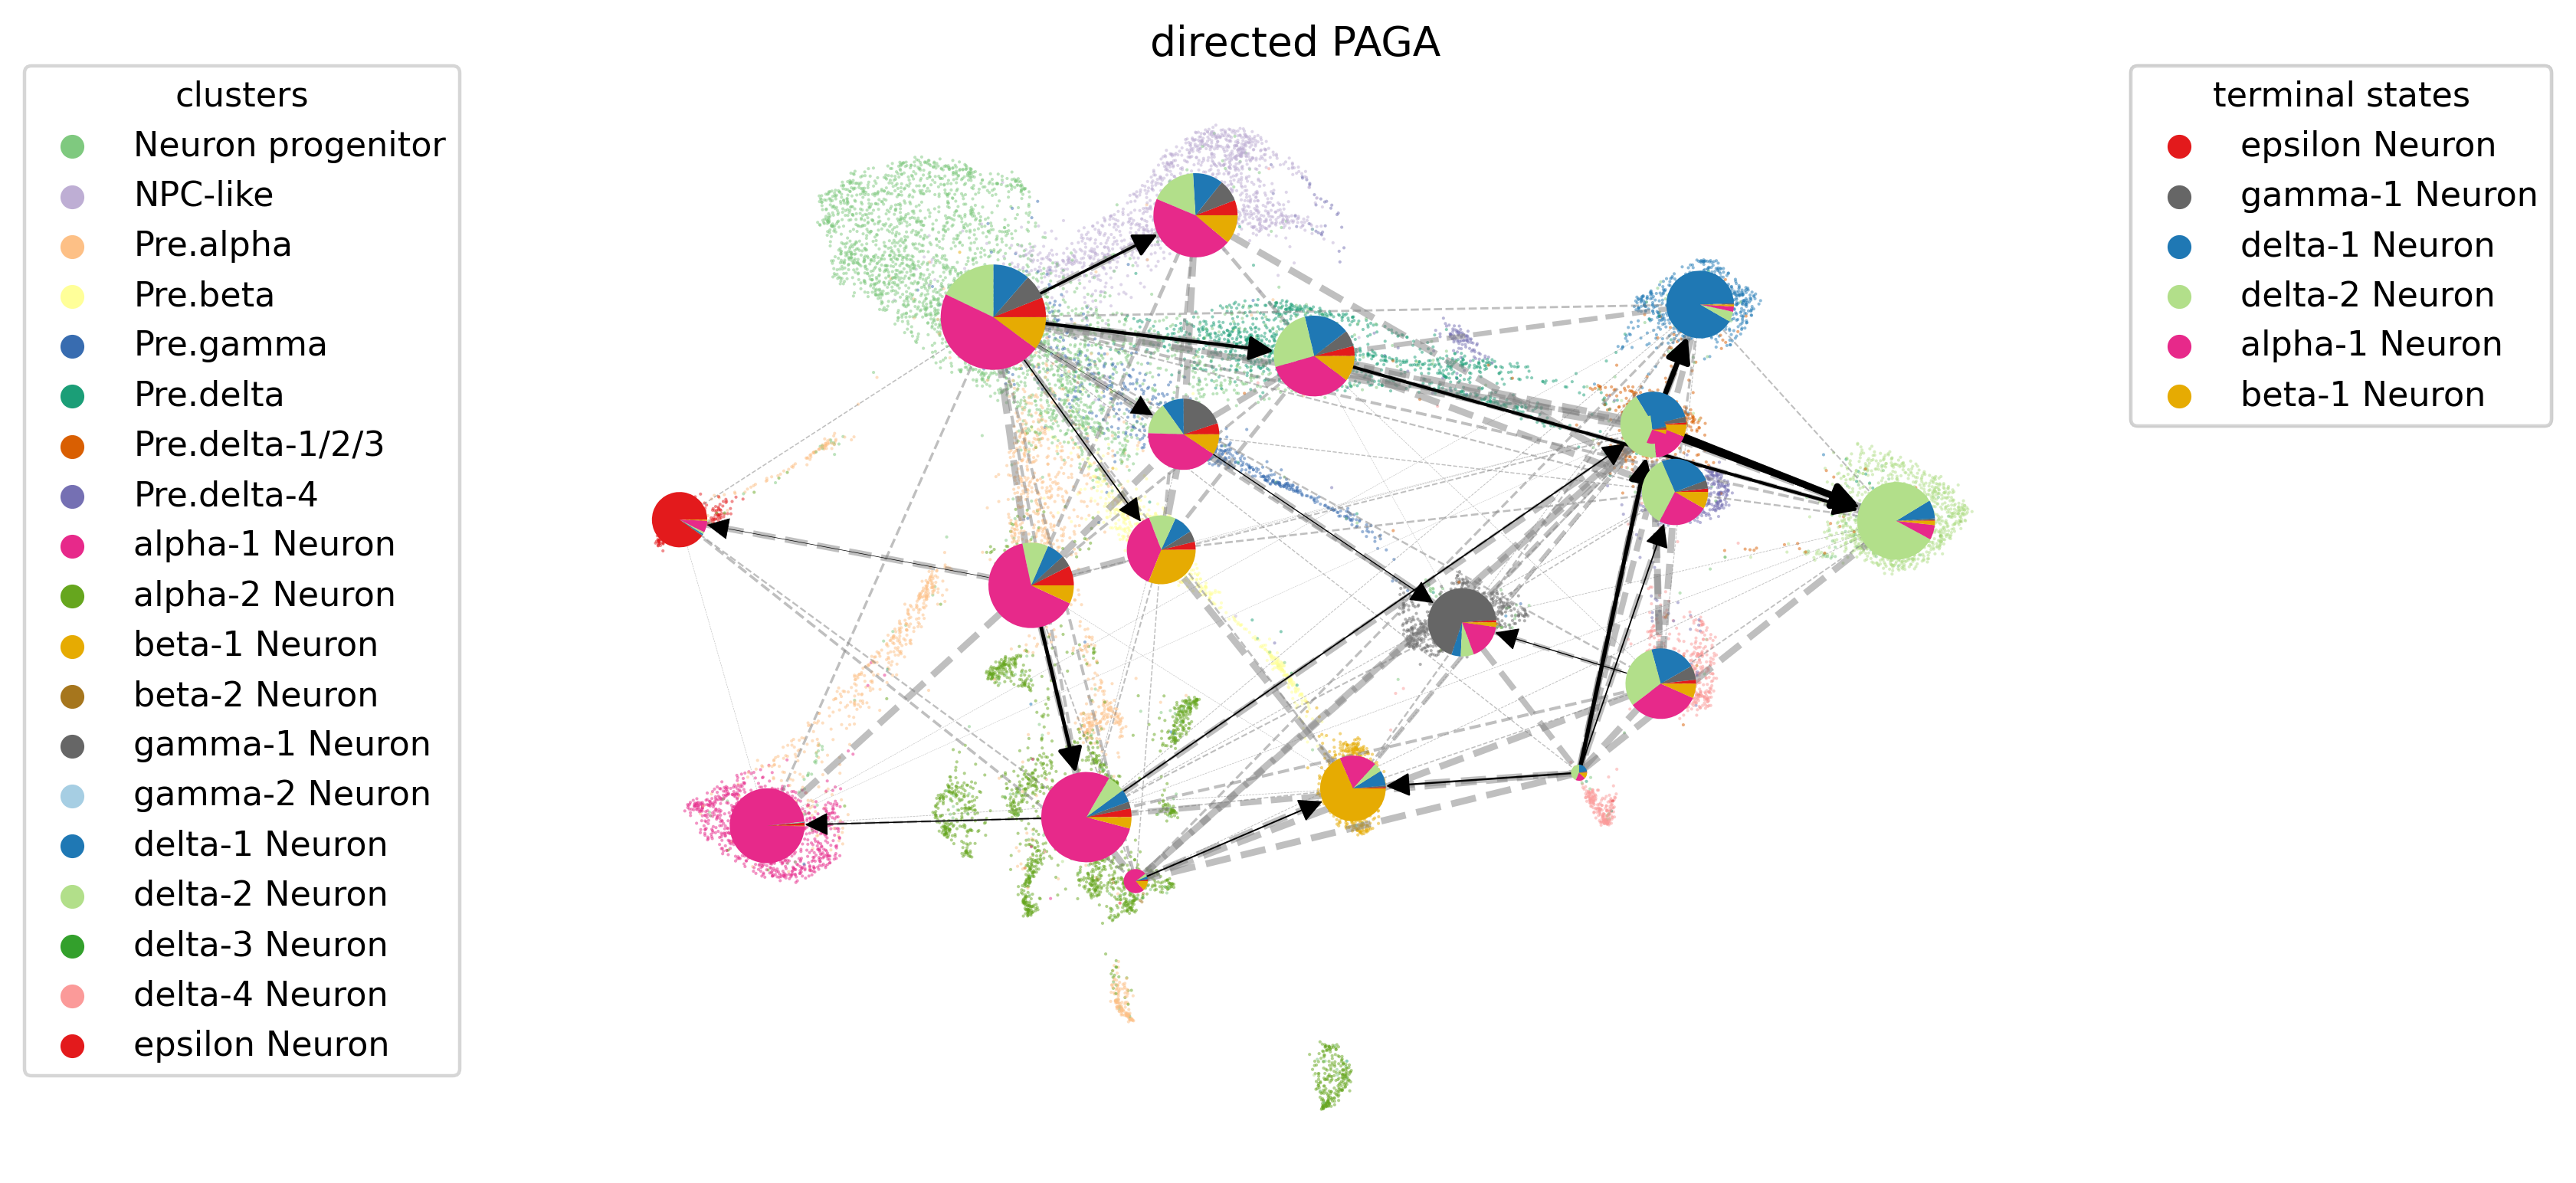

In [214]:
cr.pl.cluster_fates(adata_f, mode="paga_pie", cluster_key="clusters", basis='umap',
                    legend_kwargs={'loc': 'top right out'}, legend_loc='top left out',show = False,
                    node_size_scale=3, edge_width_scale=1, max_edge_width=2, title='directed PAGA',figsize=[6.8,5],
                    dpi = 320,save = "../02.figures/FigS8E.pdf"
                    ) # 

In [84]:
cr.tl.lineage_drivers(adata_f,method = "fischer",n_jobs = 1)

epsilon Neuron corr  epsilon Neuron pval  epsilon Neuron qval  \
Gene                                                                         
Sjc-0003666             0.684471         0.000000e+00         0.000000e+00   
Sjc-0002008             0.666500         0.000000e+00         0.000000e+00   
Sjc-0000744             0.525210         0.000000e+00         0.000000e+00   
Sjc-0009483             0.514349         0.000000e+00         0.000000e+00   
Sjc-0009053             0.464871         0.000000e+00         0.000000e+00   
...                          ...                  ...                  ...   
Sjc-0006271            -0.174230        7.348477e-119        4.199130e-117   
Sjc-0000669            -0.174324        5.474794e-119        3.220467e-117   
Sjc-0001590            -0.191404        1.209418e-143        8.340817e-142   
Sjc-0002167            -0.197284        1.026254e-152        7.330388e-151   
Sjc-0003546            -0.212129        5.602920e-177        4.669100e-175   

             epsilon Neuron ci low  epsilon Neuron ci high  \
Gene                                                         
Sjc-0003666               0.676479                0.692302   
Sjc-0002008               0.658145                0.674690   
Sjc-0000744               0.514348                0.535904   
Sjc-0009483               0.503319                0.525211   
Sjc-0009053               0.453123                0.476457   
...                            ...                     ...   
Sjc-0006271              -0.188624               -0.159762   
Sjc-0000669              -0.188717               -0.159856   
Sjc-0001590              -0.205701               -0.177025   
Sjc-0002167              -0.211546               -0.182938   
Sjc-0003546              -0.226298               -0.197871   

             gamma-1 Neuron corr  gamma-1 Neuron pval  gamma-1 Neuron qval  \
Gene                                                                         
Sjc-0003666            -0.021937         3.862203e-03         8.582673e-03   
Sjc-0002008            -0.090794         4.063047e-33         5.047263e-32   
Sjc-0000744            -0.139224         4.925783e-76         1.368273e-74   
Sjc-0009483            -0.073832         2.036085e-22         1.710996e-21   
Sjc-0009053            -0.047129         5.279284e-10         2.410632e-09   
...                          ...                  ...                  ...   
Sjc-0006271             0.026956         3.846129e-04         9.938318e-04   
Sjc-0000669            -0.075523         2.192256e-23         1.898057e-22   
Sjc-0001590            -0.056334         1.119630e-13         6.547543e-13   
Sjc-0002167             0.000866         9.091774e-01         9.402041e-01   
Sjc-0003546             0.100268         4.633450e-40         6.764160e-39   

             gamma-1 Neuron ci low  gamma-1 Neuron ci high  ...  \
Gene                                                        ...   
Sjc-0003666              -0.036808               -0.007057  ...   
Sjc-0002008              -0.105534               -0.076014  ...   
Sjc-0000744              -0.153788               -0.124599  ...   
Sjc-0009483              -0.088617               -0.059013  ...   
Sjc-0009053              -0.061968               -0.032268  ...   
...                            ...                     ...  ...   
Sjc-0006271               0.012077                0.041822  ...   
Sjc-0000669              -0.090304               -0.060708  ...   
Sjc-0001590              -0.071157               -0.041485  ...   
Sjc-0002167              -0.014017                0.015749  ...   
Sjc-0003546               0.085513                0.114980  ...   

             alpha-1 Neuron corr  alpha-1 Neuron pval  alpha-1 Neuron qval  \
Gene                                                                         
Sjc-0003666            -0.090641         5.187596e-33         1.512419e-32   
Sjc-0002008            -0.164879        2.017761e-106        1.084818e

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/home/shycheng/miniconda3/envs/py38_velo/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


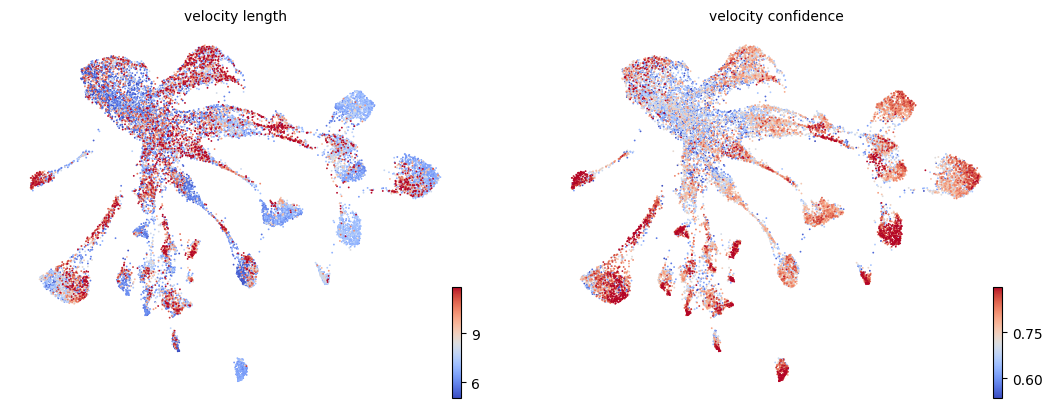

In [85]:
scv.tl.velocity_confidence(adata_f)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata_f, c=keys, cmap='coolwarm', perc=[5, 95])